0
Patient-id: 10194022
left


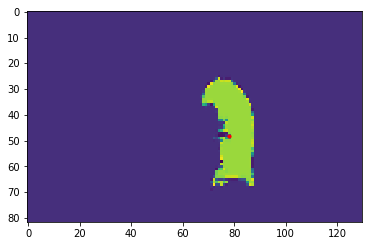

centroid: [48.84629916 70.81229607 78.09848875]
starting segmentation...
225
starting segmentation...
235


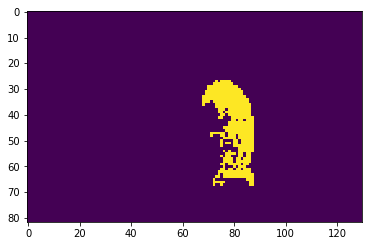

Elapsed time: 5.026 seconds.
Metrics:
Dice: 0.9084238878053311
Jacquard Index: 0.8322130519867268
True Positive Rate: 0.8398591791172935
Volumetric Similarity: 0.9183616606297018

-----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------


In [22]:
from segmentation_functions import resample, grow, erode_volume, dilate_volume
from .finding_biggest_lung import arrange_slices, normalization, creating_mask
from automaticSeeding import find_seed #confirmar que não é o primeiro metodo
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io as spio
import pydicom
import time
from segmentation_metrics import compare_volumes_lighter, Dice, Jac, TruePR, VoluM

slices_path = "G:/CTimages/"
indices_path ="G:/Plans/CT/Lungs/ok/Separated Lungs/"
seeds_path = "G:/CTimages/CT/Images/Seeds/"
separation_path = "G:/CTimages/CT/Images/Separator/"
centroid_path = "G:/CTimages/CT/Images/Centroids/New_method/"
segmentations_results_path = "G:/Plans/CT/Lungs/segmentation_results/Centroid/second_method/"
indices_folder= os.listdir(indices_path)
 
a=0
metrics = []
TP_list = []
TN_list = []
FP_list = []
FN_list = []
centroides = np.load(centroid_path+'centroides_all_method2.npy')
for num,each_mask in enumerate(indices_folder[a:1]):

    print(num)
    #Loading data--------------------------------------------------------------------------------------------------------
    opened = spio.loadmat(indices_path+'/'+each_mask, squeeze_me=True)["indexes"]
    patient_id = each_mask.split(" ", each_mask.count(each_mask))[0] 
    separador = spio.loadmat(separation_path+'/'+patient_id+'_separator', squeeze_me=True)["separator"]
    pre_region = each_mask.split("_", each_mask.count(each_mask))[1]
    region = pre_region.split("_", pre_region.count(pre_region))[0]
    print("Patient-id: "+ str(patient_id))
    print(region)
    
    #Reading the data--------------------------------------------------------------------------------------------------------
    slices= arrange_slices(slices_path,patient_id)
    normalized_volume=normalization(slices)
    normalized_array = np.array(normalized_volume)
    min_value = np.amin(normalized_array)
    #Separating left and right side------------------------------------------------------------------------------------------
    volume = np.ones(normalized_array.shape)*min_value #possible change: non-used side with minimum intensity
    cols = normalized_array.shape[2]
    
    if region =='left':
        volume[:,:,separador:cols] = normalized_array[:,:,separador:cols]
    elif region =='right':
        volume[:,:,0:separador] = normalized_array[:,:,0:separador]
    volume_resampled, spacing = resample(volume, slices, [5,5,5])
    
    eroded = erode_volume(volume_resampled,1)
    dilated = dilate_volume(eroded,1)
    
    #Mask-----------------------------------------------------------------------------------------------------------------
    lung_mask = creating_mask(opened,normalized_array)
    lung_mask_resampled, spacing = resample(lung_mask, slices, [5,5,5])
    ground_truth_boolean = np.where(lung_mask_resampled>0.5, 1, 0)
    
    #Centroids--------------------------------------------------------------------------------------------------------------
    
    centroid = centroides[a]
    
    showing = lung_mask_resampled.copy()
    #showing[tuple(int(centroid[0])]=2
    plt.imshow(showing[:,int(centroid[1]),:])
    plt.scatter([int(centroid[2])], [int(centroid[0])],c='r',s=10)
    plt.show()
    print('centroid: '+str(centroid))
    
    #Segmentation--------------------------------------------------------------------------------------------------------------------
    thresh = 225
    vizinhanca = 1
    pre_seed = tuple([int(centroid[0]),int(centroid[1]),int(centroid[2])])
    
    first_seg = np.zeros(volume_resampled.shape, dtype=np.bool)
    max_seeding = 39705+50
    min_seeding = 3257
    counter = max_seeding+50
    while counter > max_seeding or counter< min_seeding:

        print('starting segmentation...')
        start = time.time()
        seg, counter = grow(dilated,pre_seed,thresh,1,first_seg)
        result_segment_boolean = np.where(seg==True, 1, 0)
        stop = time.time()
        print(thresh)
        if counter>max_seeding:
            thresh = thresh-10
        if counter<min_seeding:
            thresh = thresh+10
    plt.imshow(seg[:,int(centroid[1]),:])
    plt.show()
    print("Elapsed time: %.3f seconds." % (stop - start))
    
    a=a+1
    #Saving------------------------------------------------------------------------------------------------------------------
    name = segmentations_results_path+"3DVolumeSegmented_"+str(patient_id)+'_'+str(region)+"_"+str(thresh)
    np.save(name, seg)
   
    #Evaluation--------------------------------------------------------------------------------------------------------------
    start=time.time()
    TP, TN, FP, FN = compare_volumes_lighter(ground_truth_boolean,result_segment_boolean)
    stop=time.time()
    TP_list.append(TP)
    FP_list.append(FP)
    TN_list.append(TN)
    FN_list.append(FN)
    
    identification = patient_id+'_'+region
    dice = Dice(TP,FP,FN)
    jac = Jac(TP,FP,FN)
    truePr = TruePR(TP,FN)
    vs = VoluM(TP,FP, FN)
    evaluation =tuple([dice,jac,truePr,vs])
    result = tuple([identification,evaluation])
    metrics.append(result)
    print('Metrics:')
    print('Dice: '+str(dice))
    print('Jacquard Index: '+str(jac))
    print('True Positive Rate: '+str(truePr))
    print('Volumetric Similarity: '+str(vs))
    #print('Mutual Information: '+str(mi))
    print('\n'+'-----------------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------------------')
    #name = segmentations_results_path+"Metrics_Tp_Fp, Tn, Fn"
    #np.save(name, metrics)
    
    del slices
    del seg
    del normalized_array
    #del volume_resampled
    

In [12]:
dice =[]
jac = []
tpr = []
vs = []

for i in metrics:
    #dice = i[1][0]
    dice.append(i[1][0])
    jac.append(i[1][1])
    tpr.append(i[1][2])
    vs.append(i[1][3])

In [25]:
dice

[0.9084238878053311,
 0.9499865658465436,
 0.9596642574026579,
 0.9638715860086248,
 0.0014435695538057743,
 0.014330660712473358,
 0.9550030199315482,
 0.9614672579325785,
 0.9607432008448247,
 0.9641997359633455,
 0.9586729174179589,
 0.9701418510068446,
 0.9679031037093111,
 0.9546723494938733,
 0.9580599617971929,
 0.9290467289719626,
 0.9620041215868109,
 0.9654880173266162,
 0.9158851946575731,
 0.9553409423470881,
 0.9664587288671911,
 0.9685352622061483,
 0.9654326595503067,
 0.9601342232921181,
 0.9227138643067847,
 0.9560042507970244,
 0.8636486122338992,
 0.9456112008616048,
 0.9522638083523692,
 0.9568806033869361,
 0.9521859322207433,
 0.956169318522966,
 0.9632072789309071,
 0.9649150163729924,
 0.959078869128061,
 0.9608175651553017,
 0.9554240631163708,
 0.9599955918007494,
 0.9402867081269105,
 0.8967537642978696,
 0.9343395617256548,
 0.9302699228791774,
 0.9662390969728065,
 0.9626350274482026,
 0.9404899691358025,
 0.9477981651376147,
 0.0011178468549808676,
 0.9423

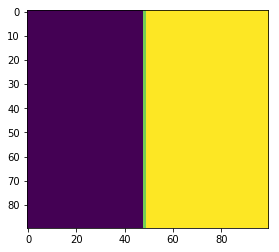

0


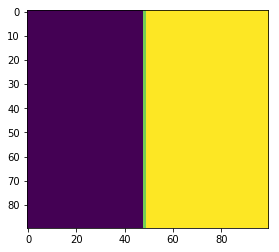

1


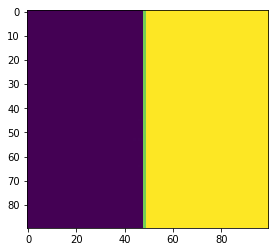

2


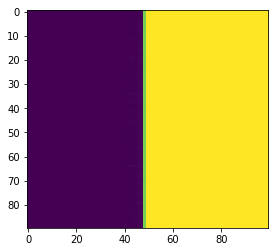

3


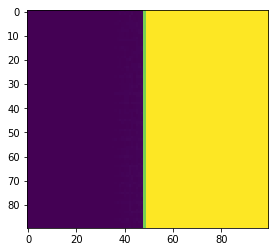

4


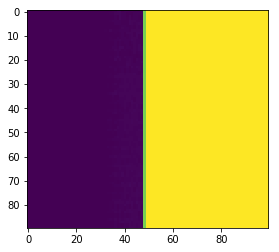

5


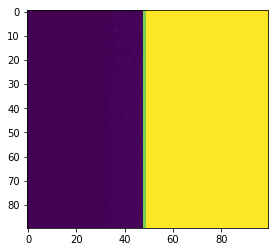

6


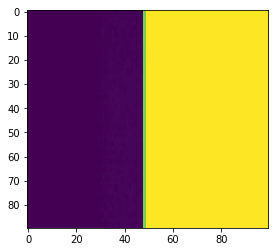

7


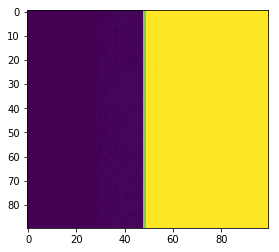

8


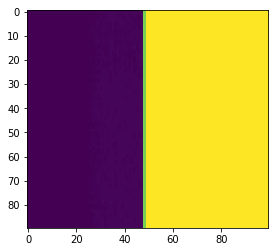

9


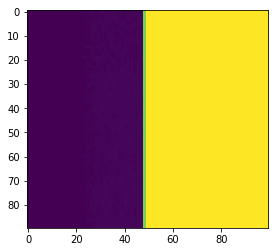

10


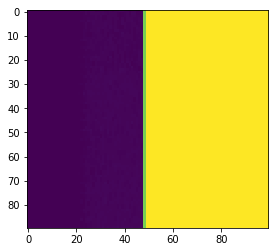

11


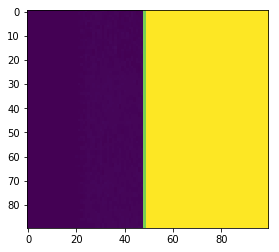

12


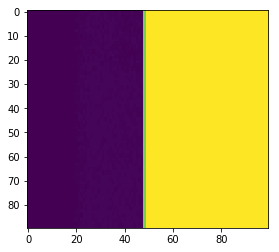

13


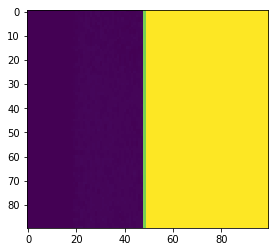

14


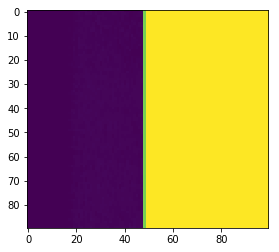

15


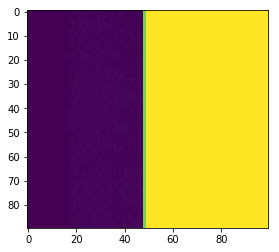

16


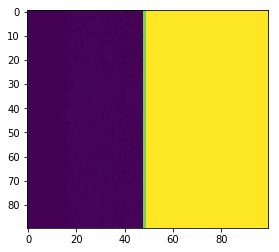

17


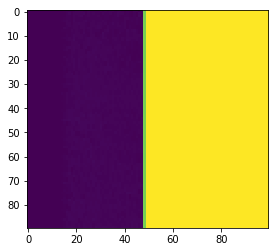

18


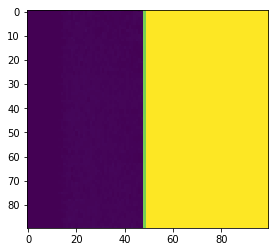

19


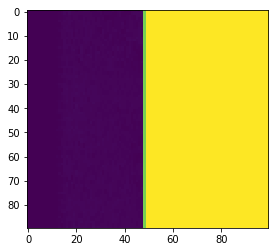

20


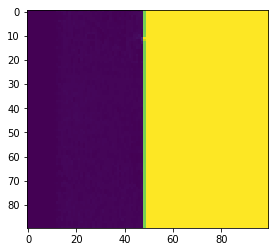

21


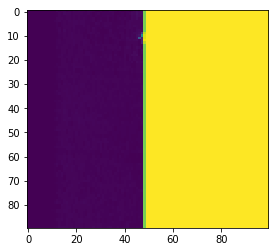

22


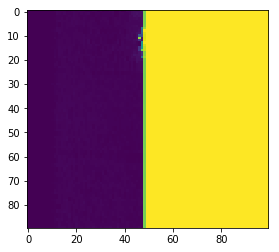

23


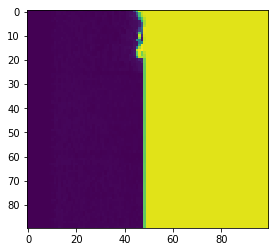

24


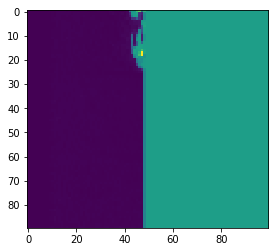

25


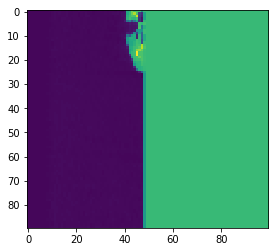

26


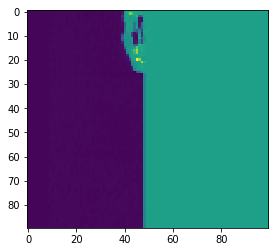

27


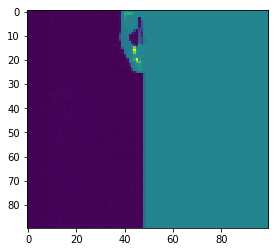

28


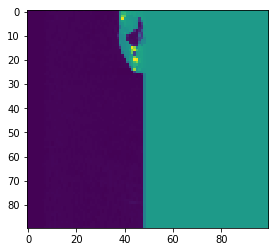

29


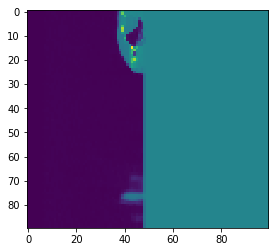

30


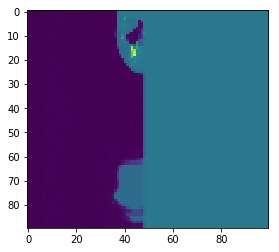

31


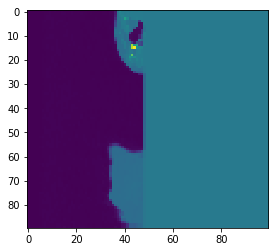

32


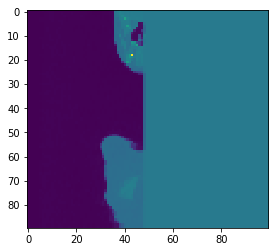

33


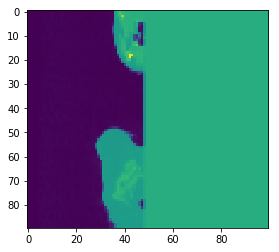

34


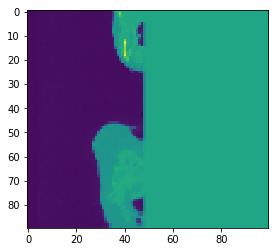

35


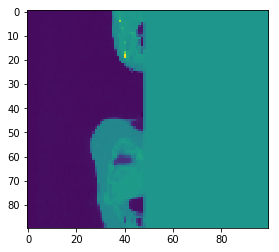

36


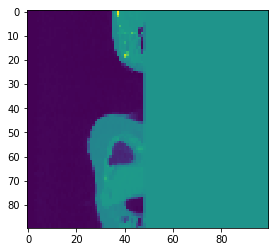

37


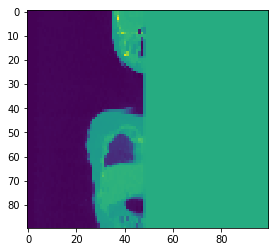

38


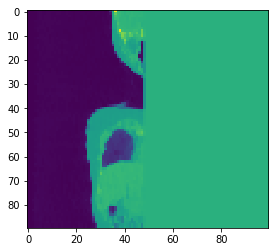

39


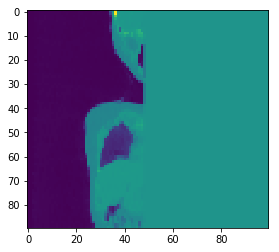

40


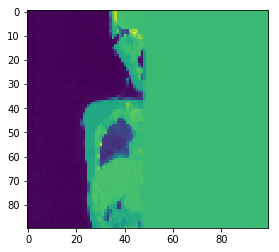

41


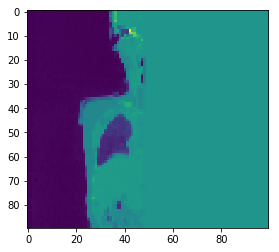

42


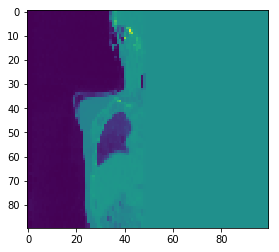

43


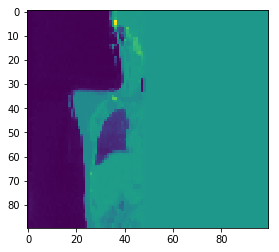

44


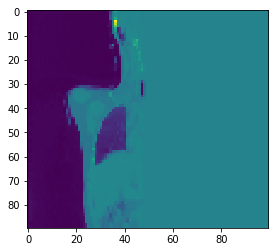

45


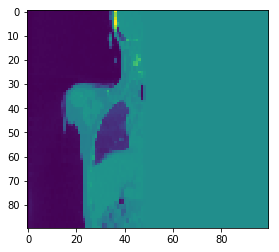

46


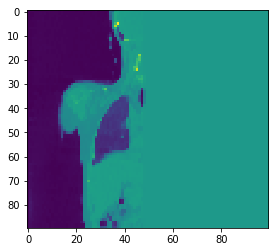

47


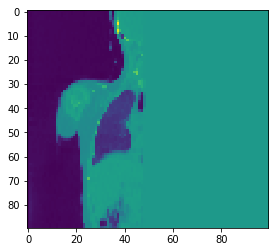

48


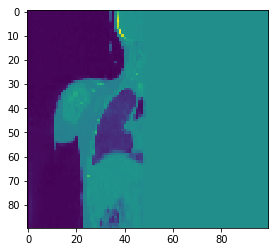

49


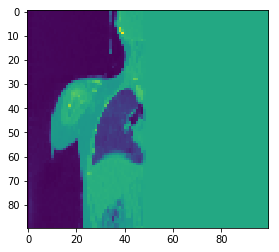

50


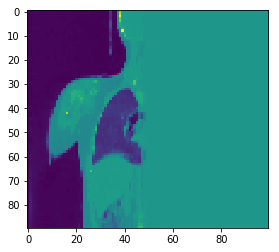

51


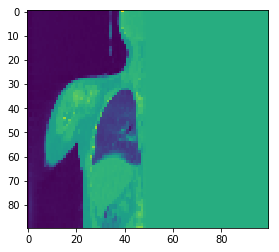

52


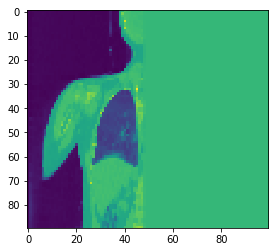

53


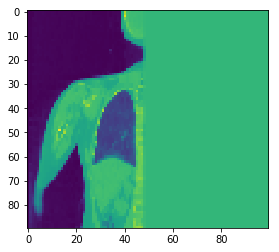

54


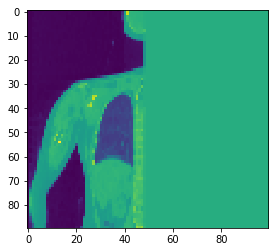

55


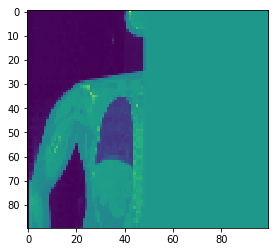

56


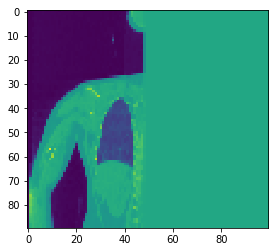

57


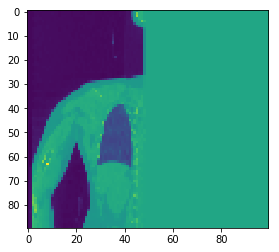

58


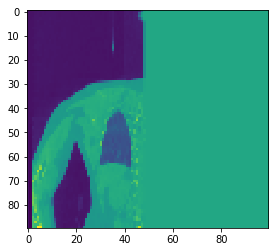

59


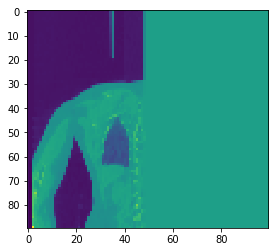

60


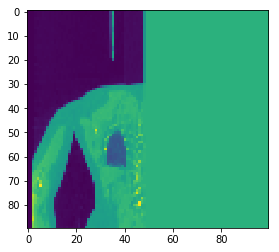

61


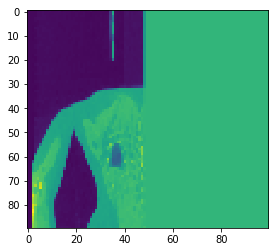

62


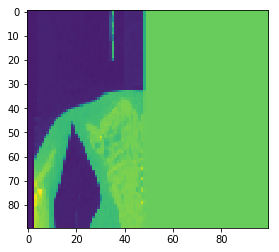

63


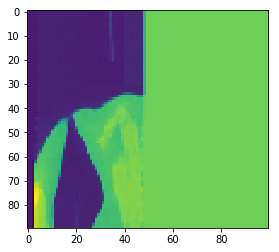

64


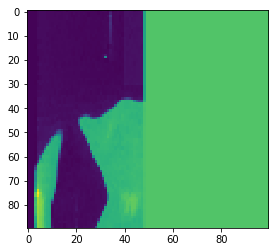

65


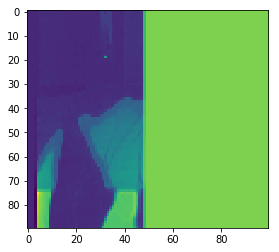

66


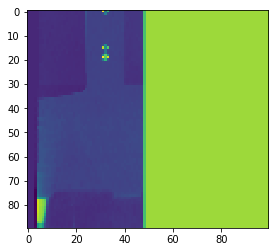

67


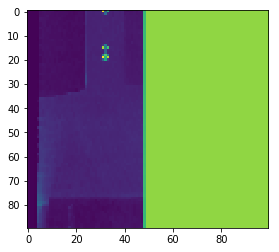

68


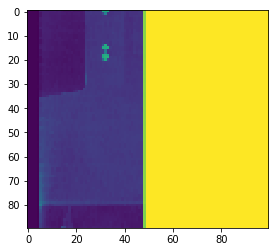

69


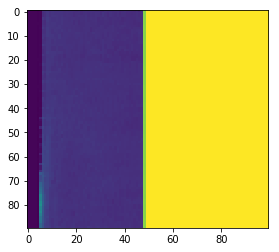

70


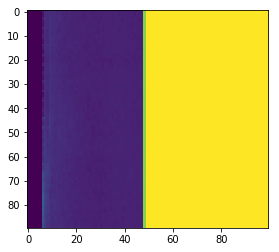

71


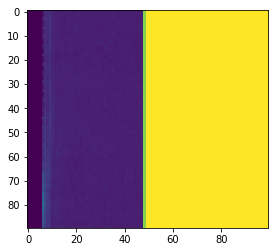

72


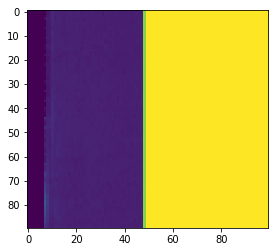

73


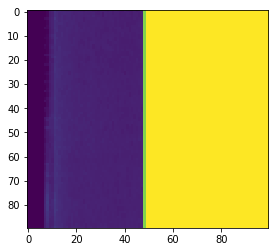

74


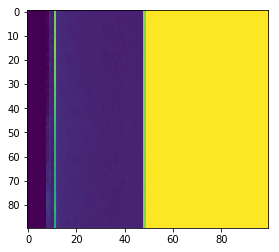

75


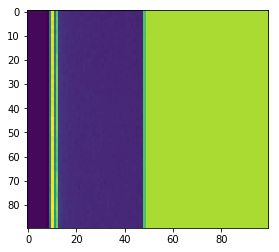

76


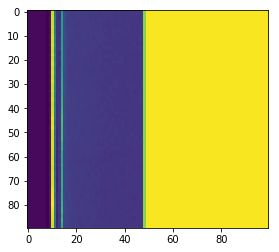

77


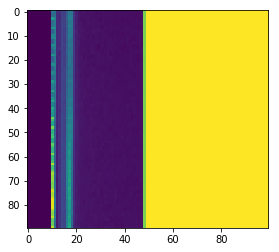

78


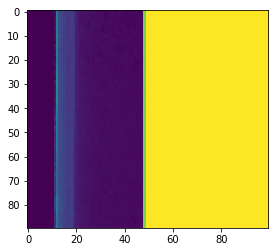

79


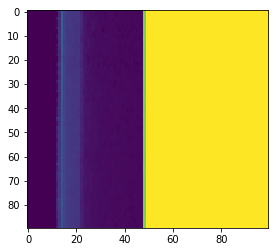

80


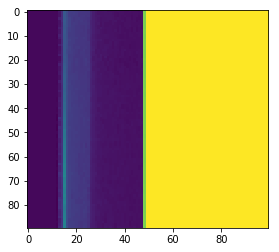

81


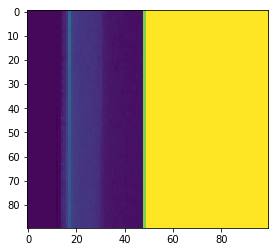

82


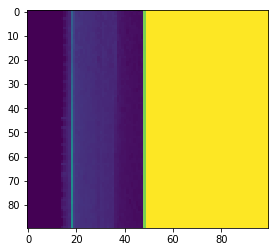

83


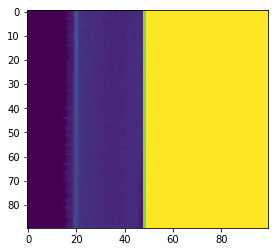

84


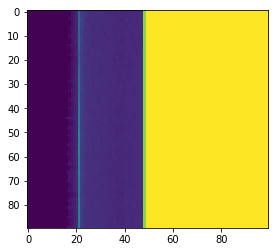

85


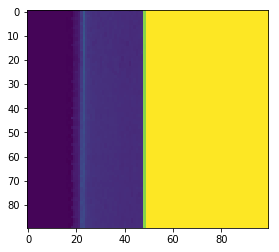

86


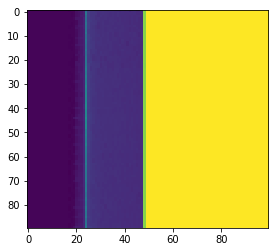

87


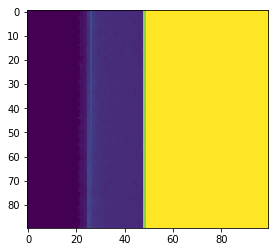

88


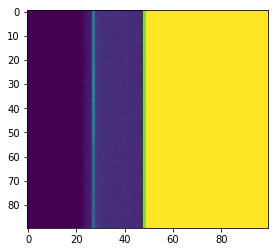

89


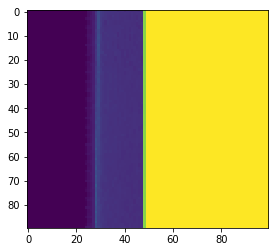

90


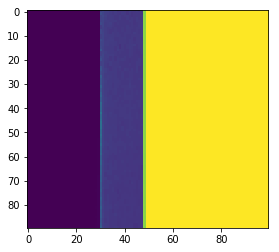

91


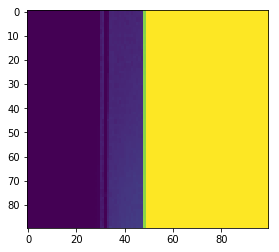

92


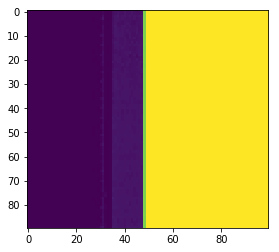

93


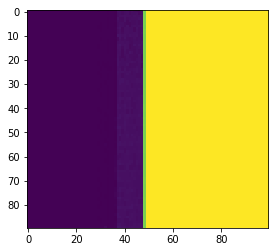

94


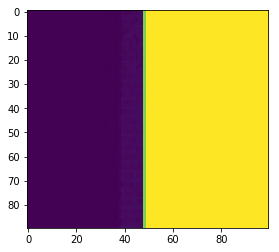

95


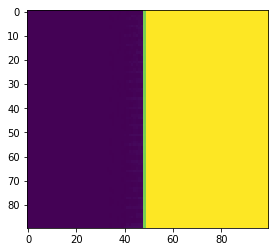

96


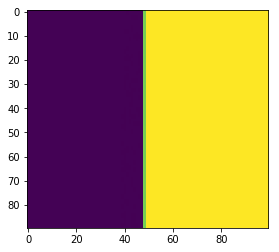

97


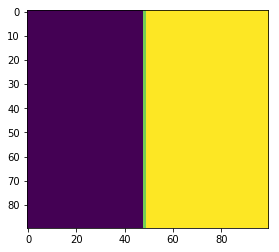

98


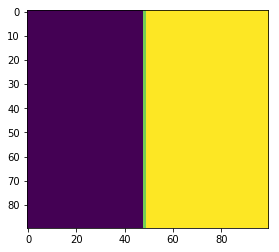

99


In [10]:
for i in range(0,100):
    fig, ax = plt.subplots()
    cs = ax.imshow(eroded[:,i,:])
    plt.show()
    print(i)
    time.sleep(1)